# Injection missteering: beam clone of operational BCMS (3bp) using single bunch with nominal skews settings



In [233]:
%run /eos/project/m/mte/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.2.2.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2017.08.24
Your IP is 172.17.0.15
2017-12-11 17:16:31
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools


In [234]:
# let's start with the matlab data
files = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.24/data/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 210 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.24/data/2017.08.24.16.23.18.210.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.24/data/2017.08.24.19.10.42.187.mat


## Load the data

In [235]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1','PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1','PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                                                         'logical_PI_KFA45.K.value',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples','PI_KFA45.CCV.value',
                                                    'PI_KFA45.AQN1.value','PI_KFA45.AQN1'],verbose=False)

## Measurement method:
starting from 90% of the kicker strength, 5 measurements bounched (RF of PS on) + 5 measurements unbounched (RF of the PS off). After the set of 10 measurements, kicker strenght gets increased of 1%.

Measurements restarted after the end because of no tomogram initially recorded.

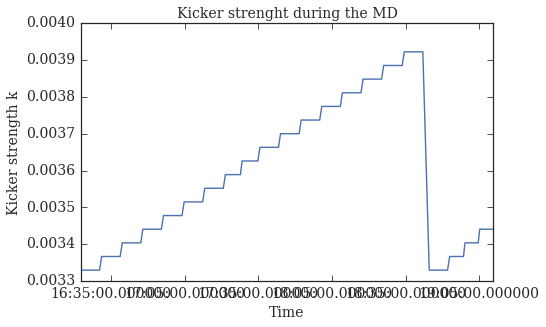

In [236]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'])
plt.xlabel('Time')
plt.ylabel('Kicker strength k')
plt.title('Kicker strenght during the MD')

## Intensity

In [237]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses_perc'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][1250]/np.max(x) )

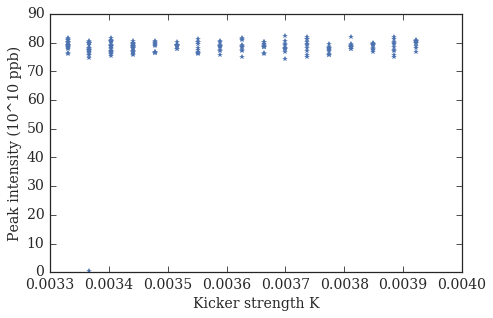

In [238]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

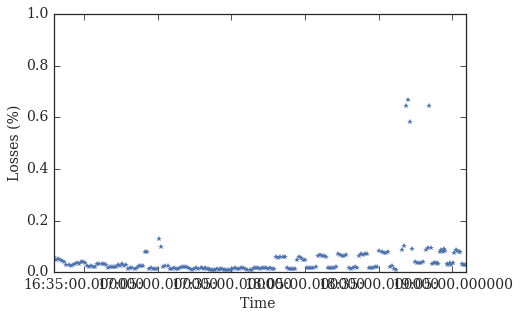

In [239]:
plt.plot(myDataFrame['Losses_perc'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.xlabel('Time ')
plt.ylabel('Losses (%)')

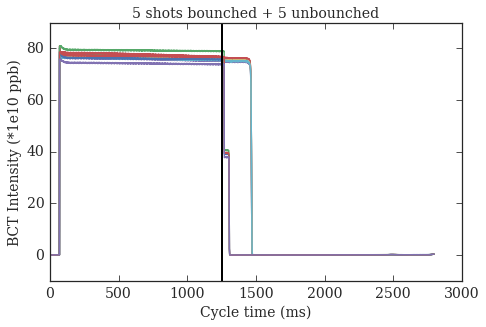

In [240]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=1250, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('5 shots bounched + 5 unbounched')

## KFA45 power supply linearity check

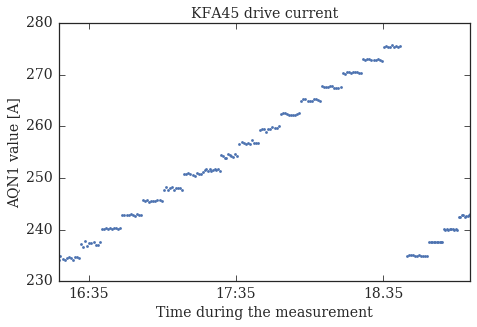

In [241]:
fig, ax = plt.subplots()
ax.plot(myDataFrame['PI_KFA45.AQN1.value'],'.')
ax.set_xticks([ 736565.69097222,    736565.73263889, 736565.77430556])
ax.set_xticklabels(['16:35','17:35','18.35'])
plt.title('KFA45 drive current')
plt.ylabel('AQN1 value [A]')
plt.xlabel('Time during the measurement')

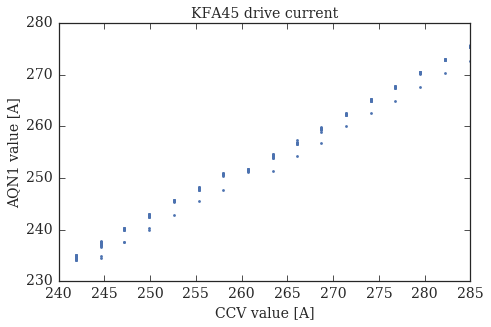

In [242]:
plt.plot(myDataFrame['PI_KFA45.CCV.value'],myDataFrame['PI_KFA45.AQN1.value'],'.')
plt.title('KFA45 drive current')
plt.xlabel('CCV value [A]')
plt.ylabel('AQN1 value [A]')

## Wire scanner

### X plane

In [243]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [244]:
#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  

In [245]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])

### Y plane

In [246]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [247]:
#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

In [248]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

### Tomogram

In [52]:
# load the dataframe from tomogram analysis
tomoDfPS = pnd.read_pickle('tomo_out_2017_08_24_ps.pkl') 
tomoDfBooster = pnd.read_pickle('tomo_out_2017_08_24_booster.pkl') 
# work ou the dataframe for the alignment
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['bunched']=False
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
# set tolerance to align the timestamps
timeTolerance = 7 # [seconds]

In [53]:
# BUNCHED DATA: match tomogram files of the PS with the dataframe timestamps
succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomoDfPS)):
    tomo_local_cs = tomoDfPS['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    #stuff to copy here
    current_dpprms = tomoDfPS['deltaP_P_RMS'].values[k]
    current_pkld = tomoDfPS['peakLineDensity'].values[k]

    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['bunched'].iloc[x] = True
            myDataFrame['deltaP_P_rms'].iloc[x] = current_dpprms
            myDataFrame['peakLineDensity'].iloc[x]=current_pkld

            
            succ_count += 1 #dummy counter
print str(succ_count) +"/"+ str(len(tomoDfPS)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

75/86 are within the timeTolerance
length of dataframe is: 210


In [54]:
# DEBUNCHED DATA: match tomogram files of the PS with the dataframe timestamps
# --> RF in the PS is off, so use dp/p of the booster
succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomoDfBooster)):
    tomo_local_cs = tomoDfBooster['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    #stuff to copy here
    current_dpprms = tomoDfBooster['deltaP_P_RMS'].values[k]
    current_pkld = tomoDfBooster['peakLineDensity'].values[k]

    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()
        existPSdata = myDataFrame['bunched'].values[x]

        if np.abs(d) <= timeTolerance and x > last_match and existPSdata==False: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['bunched'].iloc[x] = False
            myDataFrame['deltaP_P_rms'].iloc[x] = current_dpprms
            myDataFrame['peakLineDensity'].iloc[x]=current_pkld

            
            succ_count += 1 #dummy counter
print str(succ_count) +"/"+ str(len(tomoDfPS)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

78/86 are within the timeTolerance
length of dataframe is: 210


In [56]:
# discard the elements without tomogram (are probably double shots of matlab)
# discFlag = np.isnan(myDataFrame['tomoDelta'].values)
# myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

In [249]:
# manual deltaP_P_rms to preserve data with these few tomograms
myDataFrame['deltaP_P_rms']=0.85e-3


In [250]:
# also the bunched flags are fakes done that way. Correction below ...
ll = np.empty(0,dtype=bool)
for k in range(len(myDataFrame)):
    if (np.mod(k,5)==0 and np.mod(k,10)==0):
        status = True
#         print k
    elif (np.mod(k,5)==0 and (not np.mod(k,10)==0)):
        status = False
#         print k
        
    ll = np.append(ll, status)

In [251]:
ll = np.append(False, ll)
ll = np.delete(ll, len(ll)-1)
myDataFrame['bunched'] = ll

## Emitance

In [252]:
def normalised_emittance(sig, dp):
    "Calculate the normalised emittance, where sig is in mm. dp is DeltaP/P rms"
    betar = 0.915095 
#     D = 2.330216464 #at wirescanner 68
    D = 3.2 #at wirescanner 65
#     betax = 13.00860302 #at wirescanner 68
    betax = 20.11 #at wirescanner 65
    
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2 - D**2*dp**2)/betax *(betar*gammar)
    return emi*1e6

def normalised_emittance_y(sig):
    "Calculate the normalised emittance without the dispesive component"
    betar = 0.915095
    betay = 12.35 #[metres] #at wirescanner 85
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2)/betay *(betar*gammar)
    return emi*1e6
    

### Y plane

In [253]:
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance_y(x))

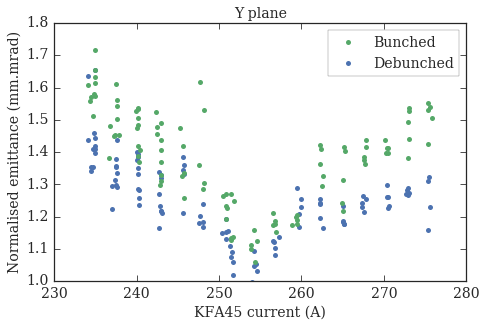

In [254]:
#bunched
plt.xlabel('KFA45 current (A)')
plt.ylabel('Normalised emittance (mm.mrad)')
#debounched
Debunched_y, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[np.invert(myDataFrame['bunched'])],myDataFrame['WS_emittance_y'].loc[np.invert(myDataFrame['bunched'])],'.',label='Debunched', marker='o', markersize=5)
Bunched_y, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[myDataFrame['bunched']],myDataFrame['WS_emittance_y'].loc[myDataFrame['bunched']],'.', label='Bunched', marker='o', markersize=5)

legend = plt.legend(handles=[Bunched_y,Debunched_y],frameon=True)

plt.title('Y plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,1.8))

plt.show()

fig.savefig('emiy_together.eps', format='eps')

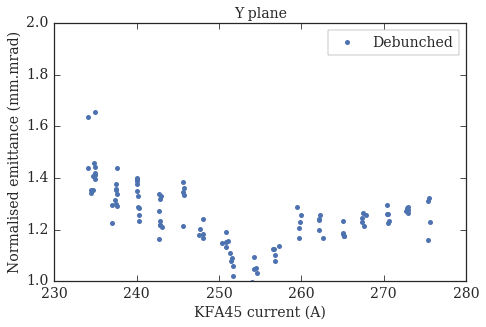

In [255]:
#bunched
plt.xlabel('KFA45 current (A)')
plt.ylabel('Normalised emittance (mm.mrad)')
#debounched
Debunched_y, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[np.invert(myDataFrame['bunched'])],myDataFrame['WS_emittance_y'].loc[np.invert(myDataFrame['bunched'])],'.',label='Debunched', marker='o', markersize=5)
# Bunched_y, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[myDataFrame['bunched']],myDataFrame['WS_emittance_y'].loc[myDataFrame['bunched']],'.', label='Bunched', marker='o', markersize=5)

legend = plt.legend(frameon=True)

plt.title('Y plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2))

plt.show()

fig.savefig('emiy_debunched.eps', format='eps')

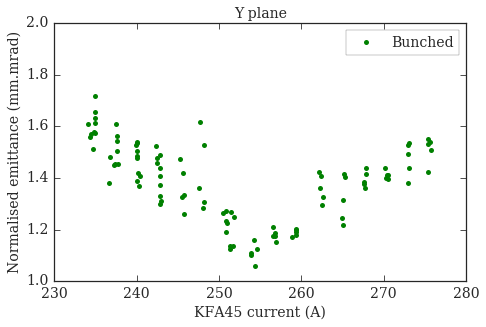

In [256]:
#bunched
plt.xlabel('KFA45 current (A)')
plt.ylabel('Normalised emittance (mm.mrad)')
#debounched
# Debunched_y, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[np.invert(myDataFrame['bunched'])],myDataFrame['WS_emittance_y'].loc[np.invert(myDataFrame['bunched'])],'.',label='Debunched', marker='o', markersize=5)
Bunched_y, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[myDataFrame['bunched']],myDataFrame['WS_emittance_y'].loc[myDataFrame['bunched']],'g.', label='Bunched', marker='o', markersize=5)

legend = plt.legend(frameon=True)

plt.title('Y plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2))

plt.show()

fig.savefig('emiy_bunched.eps', format='eps')

### X plane

In [257]:
myDataFrame['WS_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance(myDataFrame['WS_sigma_x'].values[n],myDataFrame['deltaP_P_rms'].values[n])
    
    
    

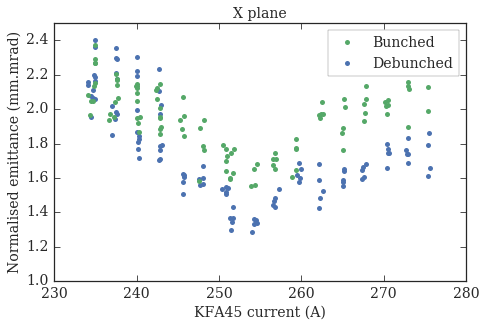

In [258]:
#bunched
plt.xlabel('KFA45 current (A)')
plt.ylabel('Normalised emittance (mm.mrad)')
#debounched
Debunched_x, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[np.invert(myDataFrame['bunched'])],myDataFrame['WS_emittance_x'].loc[np.invert(myDataFrame['bunched'])],'.',label='Debunched',marker='o', markersize=5)
Bunched_x, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[myDataFrame['bunched']],myDataFrame['WS_emittance_x'].loc[myDataFrame['bunched']],'.', label='Bunched',marker='o', markersize=5)

legend = plt.legend(handles=[Bunched_x,Debunched_x],frameon=True)
plt.title('X plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2.5))
plt.show()

fig.savefig('emix_together.eps', format='eps')

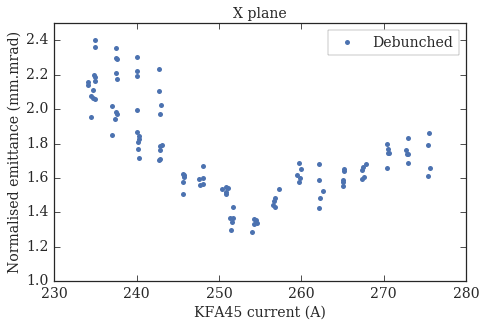

In [259]:
#bunched
plt.xlabel('KFA45 current (A)')
plt.ylabel('Normalised emittance (mm.mrad)')
#debounched
Debunched_x, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[np.invert(myDataFrame['bunched'])],myDataFrame['WS_emittance_x'].loc[np.invert(myDataFrame['bunched'])],'.',label='Debunched',marker='o', markersize=5)
# Bunched_x, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].loc[myDataFrame['bunched']],myDataFrame['WS_emittance_x'].loc[myDataFrame['bunched']],'.', label='Bunched',marker='o', markersize=5)

legend = plt.legend(frameon=True)
plt.title('X plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2.5))
plt.show()
fig.savefig('emix_debunched.eps', format='eps')

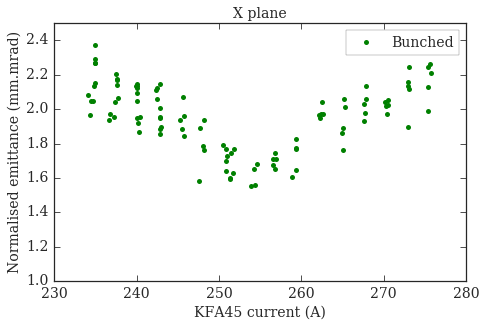

In [260]:
#bunched
plt.xlabel('KFA45 current (A)')
plt.ylabel('Normalised emittance (mm.mrad)')
#debounched
# Debunched_x, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].loc[np.invert(myDataFrame['bunched'])],myDataFrame['WS_emittance_x'].loc[np.invert(myDataFrame['bunched'])],'.',label='Debunched',marker='o', markersize=5)
Bunched_x, = plt.plot(myDataFrame['PI_KFA45.AQN1.value'].loc[myDataFrame['bunched']],myDataFrame['WS_emittance_x'].loc[myDataFrame['bunched']],'g.', label='Bunched',marker='o', markersize=5)

legend = plt.legend(frameon=True)
plt.title('X plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2.5))
plt.show()

fig.savefig('emix_bunched.eps', format='eps')

<function matplotlib.pyplot.show>

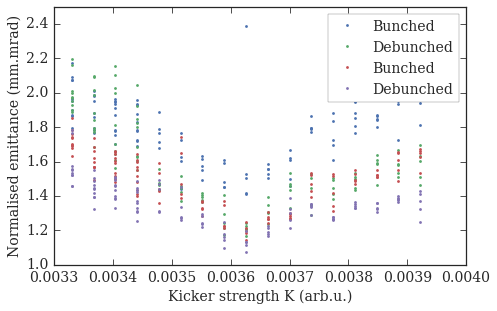

In [191]:
# comparison of X and Y
Bunched_x, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].loc[myDataFrame['bunched']],myDataFrame['WS_emittance_x'].loc[myDataFrame['bunched']],'.', label='Bunched')
Debunched_x, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].loc[np.invert(myDataFrame['bunched'])],myDataFrame['WS_emittance_x'].loc[np.invert(myDataFrame['bunched'])],'.',label='Debunched')
Bunched_y, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].loc[myDataFrame['bunched']],myDataFrame['WS_emittance_y'].loc[myDataFrame['bunched']],'.', label='Bunched')
Debunched_y, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'].loc[np.invert(myDataFrame['bunched'])],myDataFrame['WS_emittance_y'].loc[np.invert(myDataFrame['bunched'])],'.',label='Debunched')

plt.xlabel('Kicker strength K (arb.u.)')
plt.ylabel('Normalised emittance (mm.mrad)')

legend = plt.legend(handles=[Bunched_x,Debunched_x,Bunched_y,Debunched_y],frameon=True)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2.5))

plt.show

## Laslett tune shift

In [31]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [32]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

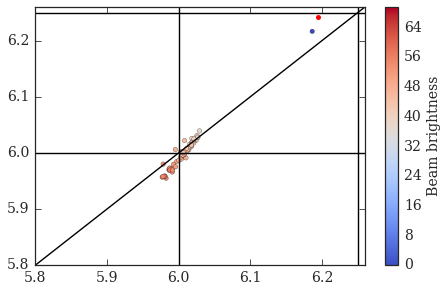

In [33]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.195
Qy = 6.243
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([5.8, 6.26])
plt.ylim([5.8, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

plt.show()

## Export the data

In [34]:
myDataFrame[['WS_intensity','bunched','logical_PI_KFA45.K.value','peakLineDensity','WS_emittance_x','WS_emittance_y','deltaP_P_rms']].to_csv('dataFrameExported.csv')